In [4]:
%pip install urllib3

## Importing Libraries and Defining Some Constants

In [2]:
## Imports
import os
import re
import pandas as pd
import numpy as np
import string
import collections
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import urllib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



## Constants
CUTOFF = 0  # frequency threshold for including a token in the vocabulary
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 50
DOWNSAMPLE_HOTEL = None  # number of rows for the hotel dataset
DOWNSAMPLE_SCIFI = None  # number of rows for the scifi dataset

N_EPOCHS_HOTEL = 12 # number of training epochs for the hotel dataset
N_EPOCHS_SCIFI = 2 # number of training epochs for the sci-fi dataset

## Check if MPS is available
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print('MPS is available')

MPS is available


## Class Definitions
Here, we define the three "helper" classes Vocabulary, CBOWVectorizer and TextDataset

In [3]:
class Vocabulary(object):
  """Class to process text and extract Vocabulary for mapping"""
  def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
    """
    Args:
        token_to_idx (dict): a pre-existing map of tokens to indices
        add_unk (bool): a flag that indicates whether to add the UNK token
        unk_token (str): the UNK token to add into the Vocabulary
    """
    if token_to_idx is None:
        token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx: token
                          for token, idx in self._token_to_idx.items()}
    self._add_unk = add_unk
    self._unk_token = unk_token
    self.unk_index = -1
    if add_unk:
        self.unk_index = self.add_token(unk_token)

  def to_serializable(self):
    """ returns a dictionary that can be serialized """
    return {'token_to_idx': self._token_to_idx,
            'add_unk': self._add_unk,
            'unk_token': self._unk_token}

  @classmethod
  def from_serializable(cls, contents):
    """ instantiates the Vocabulary from a serialized dictionary """
    return cls(**contents)

  def add_token(self, token):
    """Update mapping dicts based on the token.
    Args:
        token (str): the item to add into the Vocabulary
    Returns:
        index (int): the integer corresponding to the token
    """
    if token in self._token_to_idx:
        index = self._token_to_idx[token]
    else:
        index = len(self._token_to_idx)
        self._token_to_idx[token] = index
        self._idx_to_token[index] = token
    return index

  def lookup_token(self, token):
    """Retrieve the index associated with the token
      or the UNK index if token isn't present.
        Args:
          token (str): the token to look up
      Returns:
          index (int): the index corresponding to the token
      Notes:
          `unk_index` needs to be >=0 (having been added into the Vocabulary)
            for the UNK functionality
      """
    if self._add_unk:
        return self._token_to_idx.get(token, self.unk_index)
    else:
        return self._token_to_idx[token]
        
  def lookup_index(self, index):
    """Return the token associated with the index
    Args:
        index (int): the index to look up
    Returns:
        token (str): the token corresponding to the index
    Raises:
        KeyError: if the index is not in the Vocabulary
    """
    if index not in self._idx_to_token:
        raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __str__(self):
      return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
      return len(self._token_to_idx)


class CBOWVectorizer(object):
  """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
  def __init__(self, text_vocab, word_counts):
    """ Args:
            text_vocab (Vocabulary): maps words to integers
    """
    self.text_vocab = text_vocab
    self.word_counts = word_counts

  
  def vectorize(self, context, vector_length=-1):
    """ Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
    """
    indices = \
        [self.text_vocab.lookup_token(token) for token in context.split(' ')]
    if vector_length < 0:
        vector_length = len(indices)
    out_vector = np.zeros(vector_length, dtype=np.int64)
    out_vector[:len(indices)] = indices
    #out_vector[len(indices):] = self.text_vocab.mask_index
    return out_vector


  @classmethod
  def from_dataframe(cls, text_df, cutoff=CUTOFF):
    """Instantiate the vectorizer from the dataset dataframe
    Args:
      text_df (pandas.DataFrame): the dataset
      cutoff (int): the parameter for frequency-based filtering
    Returns:
      an instance of the CBOWVectorizer
    """
    text_vocab = Vocabulary(add_unk=True)
    # Add top words if count > provided count
    word_counts = Counter()
    for text in text_df.iloc[:, 0]:
        for word in text.split(" "):
            if word not in string.punctuation:
                word_counts[word] += 1
    for word, count in word_counts.items():
        if count > cutoff:
            text_vocab.add_token(word)
    return cls(text_vocab, word_counts)

  @classmethod
  def from_serializable(cls, contents):
      """Intantiate a CBOWVectorizer from a serializable dictionary
      Args:
          contents (dict): the serializable dictionary
      Returns:
          an instance of the CBOWVectorizer class
      """
      text_vocab = Vocabulary.from_serializable(contents['text_vocab'])
      return cls(text_vocab=text_vocab)

  def to_serializable(self):
      """Create the serializable dictionary for caching
      Returns:
          contents (dict): the serializable dictionary
      """
      return {'text_vocab': self.text_vocab.to_serializable()}


In [4]:

class TextDataset(Dataset):
  def __init__(self, text_df, vectorizer):
    """
    The TextDataset encapsulates the datasets and their vectorizers. It implements the __getitem__ and __len__ functions
    which are used by the PyTorch DataLoader class to construct batches.
    Args:
        text_df (pandas.DataFrame): the dataset
        vectorizer (TextVectorizer): vectorizer instantiated from dataset
    """
    self.text_df = text_df
    self._vectorizer = vectorizer
    self.train_df = self.text_df
    self.train_size = len(self.train_df)
    self._lookup_dict = {'train': (self.train_df, self.train_size)}
    self.set_split('train')

  @classmethod
  def load_dataset_and_make_vectorizer(cls, text_csv):
      """Load dataset and make a new vectorizer from scratch
      Args:
        text_csv (str): location of the dataset
      Returns:
        an instance of TextDataset
      """
      text_df = pd.read_csv(text_csv)
      return cls(text_df, CBOWVectorizer.from_dataframe(text_df))

  def get_vectorizer(self):
      """ returns the vectorizer """
      return self._vectorizer

  def set_split(self, split="train"):
      """ selects the splits in the dataset using a column in the dataframe
      Args:
          split (str): one of "train", "val", or "test"
      """
      self._target_split = split
      self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
      return self._target_size

  def __getitem__(self, index):
      """the primary entry point method for PyTorch datasets
      Args:
          index (int): the index to the data point
      Returns:
          a dict of the data point's features (x_data) and label (y_target)
      """
      row = self._target_df[index]
      text_vector = \
          self._vectorizer.vectorize(" ".join(row[0]))
      left_out_index = \
          self._vectorizer.text_vocab.lookup_token(row[1])
      return {'x_data': text_vector,
              'y_target': left_out_index}

  def get_num_batches(self, batch_size):
      """Given a batch size, return the number of batches in the dataset
      Args:
          batch_size (int)
      Returns:
          number of batches in the dataset
      """
      return len(self) // batch_size

## Helper Function Definitions
Here, we define the some helper functions for loading datasets, preprocessing, generating the correct training data format (tuples of [[context words], target]) as well as to generate training batches

In [5]:
## Load dataset
def load_dataset(filename, col_names):
    df = pd.read_csv(filename, sep=',')
    df.columns = col_names
    return df


## Preprocess helper functions
def preprocess_hotel(text):
  text = text.lower()
  text = re.sub(r"([.,!?])", r" \1 ", text) ## add whitespace around punctuation symbols
  text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text) ## remove extraneous symbols that aren’t punctuation
  return text

def preprocess_scifi(text):
  text = text.lower()
  text = re.sub(r"([.,!?])", r" \1 ", text) ## add whitespace around punctuation symbols
  text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text) ## remove extraneous symbols that aren’t punctuation
  return text



## Generate tuples of (context, left_out_word)
def generate_training_data(df, context_size, col_idx_of_training_data = 0):
    training_data = []
    ## Iterrate over the rows
    for index, row in df.iterrows():
        ## Check if row has at least length of 2*context_size + 1
        if len(row.iloc[col_idx_of_training_data].split()) >= 2*context_size + 1:
            ## Split the row into words
            words = row.iloc[col_idx_of_training_data].split()
            ## Iterate over the words
            for i in range(context_size, len(words) - context_size):
                ## get the context words
                context_words = words[i-context_size:i] + words[i+1:i+context_size+1]
                ## get the target word
                target_word = words[i]
                ## append the context words and target word to the training data
                training_data.append((context_words, target_word))
    return training_data



## Helper function to generate batches that wraps the PyTorch DataLoader
def generate_batches(dataset, batch_size, shuffle=True,
                      drop_last=True, device="cpu"):
     """
     A generator function which wraps the PyTorch DataLoader. It will
       ensure each tensor is on the write device location.
     """
     dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                             shuffle=shuffle, drop_last=drop_last)
     for data_dict in dataloader:
         out_data_dict = {}
         for name, tensor in data_dict.items():
             out_data_dict[name] = data_dict[name].to(device)
         yield out_data_dict

## Load Datasets
Now, we load the two datasets from the shared drive

In [6]:
## Load Hotel Data Sets
url = 'https://drive.google.com/file/d/1ihP1HZ8YHVGGIEp1RHxXdt3PPIi12xvL/view'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

tripadvisor_df = load_dataset(path, ['text', 'rating'])

## Inspect the Data
print('data set size: ', tripadvisor_df.shape)

tripadvisor_df.head()

data set size:  (20491, 2)


,text,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
## Load SCIFI Data Sets
url = 'https://drive.google.com/file/d/10ehW4jZND3QA29v9aNboYUett5-swuNe/view'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

# Assign the open file to a variable
webFile = urllib.request.urlopen(path)

# Read the file contents to a variable.
#this file is of type bit
file_contents = webFile.read()

#Convert to a pd.DataFrame with each sentence being one row in column "text"
scifi_df = pd.DataFrame({"text": str(file_contents).split(".")})

with pd.option_context('display.max_colwidth', None):
  display(scifi_df.head(30))

,text
0,"b'MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc"
1,", Kingston, New York"
2,"Volume #, No"
3,#
4,"Copyright # by Quinn Publishing Company, Inc"
5,"Application for Entry\' as Second Class matter at Post Office, Buffalo, New York, pending"
6,Subscription # for # issues in U
7,S
8,and Possessions: Canada # for # issues; elsewhere #
9,Aiiow four weeks for change of address


## Preprocessing
Next, we apply some preprocessing and clean the two datasets

In [8]:
## Preprocess Hotel Data
tripadvisor_df_preprocessed = tripadvisor_df.copy()
tripadvisor_df_preprocessed.text = tripadvisor_df_preprocessed.text.apply(preprocess_hotel)
## Drop column rating as not needed for this exercise
tripadvisor_df_preprocessed.drop('rating', axis=1, inplace=True)

with pd.option_context('display.max_colwidth', None):
  display(tripadvisor_df_preprocessed.head())

,text
0,"nice hotel expensive parking got good deal stay hotel anniversary , arrived late evening took advice previous reviews did valet parking , check quick easy , little disappointed non existent view room room clean nice size , bed comfortable woke stiff neck high pillows , not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway , maybe just noisy neighbors , aveda bath products nice , did not goldfish stay nice touch taken advantage staying longer , location great walking distance shopping , overall nice experience having pay parking night ,"
1,"ok nothing special charge diamond member hilton decided chain shot th anniversary seattle , start booked suite paid extra website description not , suite bedroom bathroom standard hotel room , took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast , got kidding , embassy suits sitting room bathroom bedroom unlike kimpton calls suite , day stay offer correct false advertising , send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution , send email trip guest survey did not follow email mail , guess tell concerned guest . the staff ranged indifferent not helpful , asked desk good breakfast spots neighborhood hood told no hotels , gee best breakfast spots seattle block away convenient hotel does not know exist , arrived late night pm inside run bellman busy chating cell phone help bags . prior arrival emailed hotel inform th anniversary half really picky wanted make sure good , got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate , told needed foam pillows , arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property , impressed left morning shopping room got short trips hours , beds comfortable . not good ac heat control x inch screen bring green shine directly eyes night , light sensitive tape controls . this not start hotel clean business hotel super high rates , better chain hotels seattle ,"
2,"nice rooms not experience hotel monaco seattle good hotel n t level . positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized , missed separate wakeup calls , concierge busy hard touch , did n t provide guidance special requests . tv hard use ipod sound dock suite non functioning . decided book mediterranean suite night weekend stay st choice rest party filled , comparison w spent night larger square footage room great soaking tub whirlpool jets nice shower . before stay hotel arrange car service price tip reasonable driver waiting arrival . checkin easy downside room picked person jacuzi tub no bath accessories salts bubble bath did n t stay , night got a checked voucher bottle champagne nice gesture fish waiting room , impression room huge open space felt room big , tv far away bed chore change channel , ipod dock broken disappointing . in morning way asked desk check thermostat said f degrees warm try cover face night bright blue light kept , got room night no , st drop desk , called maintainence came look thermostat told play settings happy digital box wo n t work , asked wakeup am morning did n t happen , called later pm nap wakeup forgot , am wakeup morning yep forgotten . the bathroom facilities great room surprised room sold whirlpool bath tub n t bath amenities , great relax water jets going ,"
3,"unique , great stay , wonderful time hotel monaco , location excellent short stroll main downtown shopping area , pet friendly room showed no signs animal hair smells , monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy , goldfish na

In [9]:
## Preprocess SCIFI Data
scifi_df_preprocessed = scifi_df.copy()
scifi_df_preprocessed.text = scifi_df_preprocessed.text.apply(preprocess_scifi)

with pd.option_context('display.max_colwidth', None):
  display(scifi_df_preprocessed.head(30))

,text
0,"b march all stories new and complete publisher editor if is published bi monthly by quinn publishing company , inc"
1,", kingston , new york"
2,"volume , no"
3,
4,"copyright by quinn publishing company , inc"
5,"application for entry as second class matter at post office , buffalo , new york , pending"
6,subscription for issues in u
7,s
8,and possessions canada for issues elsewhere
9,aiiow four weeks for change of address


## Optional Downsampling
If desired, the two constants DOWNSAMPLE_HOTEL and DOWNSAMPLE_SCIFI can be set to a non-None integer in order to get a sample from the datasets.

Currently, the two constants are set to "None" -> the entire dataset is used

In [10]:
## Downsample the data for faster training

if DOWNSAMPLE_HOTEL:
    tripadvisor_df_preprocessed = tripadvisor_df_preprocessed.sample(DOWNSAMPLE_HOTEL, random_state=42)

if DOWNSAMPLE_SCIFI:
    scifi_df_preprocessed = scifi_df_preprocessed.sample(DOWNSAMPLE_SCIFI, random_state=42)

print('Hotel data set size used for training: ', tripadvisor_df_preprocessed.shape)
print('SCIFI data set size used for training: ', scifi_df_preprocessed.shape)

Hotel data set size used for training:  (20491, 1)
SCIFI data set size used for training:  (1227345, 1)


## Split Sentences Into Subsentences/Subsets
Since different parts of a sentence have different semantic meanings, we need to split these sentencens into different parts and train CBOW separately on each part!

For this, we split each sentence into its subsets/subsentences based on punctuation symbols [.,;!?]

In [11]:
## Split the texts into subsentences based on punctuations since otherwise, the CBOW would ignore subsentences (leading to wrong embeddings) ##

## Iterate over the rows of the dataframe and split the review into subsentences based on the punctuation symbols and store each subsentence in a new row
tripadvisor_df_preprocessed_split = tripadvisor_df_preprocessed.text.str.split('[.,;!?]', expand=True).stack().reset_index(level=1, drop=True).to_frame('text')

## Iterate over the rows of the dataframe and split the review into subsentences based on the punctuation symbols and store each subsentence in a new row
scifi_df_preprocessed_split = scifi_df_preprocessed.text.str.split('[.,;!?]', expand=True).stack().reset_index(level=1, drop=True).to_frame('text')

## Generate the Vectorizer and Vocabularies for the two Datasets
Now, we create the Vectorizer and the Vocabularies

In [12]:
## Tripadvisor data set: Generate Vectorizer and Vocabulary from the data set
vect_trip = CBOWVectorizer.from_dataframe(tripadvisor_df_preprocessed_split)
vocab_trip = vect_trip.text_vocab
vocab_size_trip = len(vocab_trip)
word_counts_trip = vect_trip.word_counts
print('vocab size of tripadvisor data set: ', vocab_size_trip)

vocab size of tripadvisor data set:  49130


In [13]:
## SCIFI data set: Generate Vectorizer and Vocabulary from the data set
vect_scifi = CBOWVectorizer.from_dataframe(scifi_df_preprocessed_split)
vocab_scifi = vect_scifi.text_vocab
vocab_size_scifi = len(vocab_scifi)
word_counts_scifi = vect_scifi.word_counts
print('vocab size of SCIFI data set: ', vocab_size_scifi)

vocab size of SCIFI data set:  165072


## Generate Tuples of ((Context), Left_out_Word)
Here, we create tuples of context words and the target (i.e., left-out-word)

In [90]:
## Tripadvisor: Generate training data
training_data_trip = generate_training_data(tripadvisor_df_preprocessed_split, CONTEXT_SIZE)
print('Tripadvisor training data size: ', len(training_data_trip))
display('training data tuples: ', training_data_trip[:10])

Tripadvisor training data size:  1108681


'training data tuples: '

[(['nice', 'hotel', 'parking', 'got'], 'expensive'),
 (['hotel', 'expensive', 'got', 'good'], 'parking'),
 (['expensive', 'parking', 'good', 'deal'], 'got'),
 (['parking', 'got', 'deal', 'stay'], 'good'),
 (['got', 'good', 'stay', 'hotel'], 'deal'),
 (['good', 'deal', 'hotel', 'anniversary'], 'stay'),
 (['arrived', 'late', 'took', 'advice'], 'evening'),
 (['late', 'evening', 'advice', 'previous'], 'took'),
 (['evening', 'took', 'previous', 'reviews'], 'advice'),
 (['took', 'advice', 'reviews', 'did'], 'previous')]

In [116]:
## SCIFI: Generate training data
training_data_scifi = generate_training_data(scifi_df_preprocessed_split, CONTEXT_SIZE)
print('SCIFI training data size: ', len(training_data_scifi))
display('training data tuples: ', training_data_scifi[:10])

SCIFI training data size:  8133810


'training data tuples: '

[(['b', 'march', 'stories', 'new'], 'all'),
 (['march', 'all', 'new', 'and'], 'stories'),
 (['all', 'stories', 'and', 'complete'], 'new'),
 (['stories', 'new', 'complete', 'publisher'], 'and'),
 (['new', 'and', 'publisher', 'editor'], 'complete'),
 (['and', 'complete', 'editor', 'if'], 'publisher'),
 (['complete', 'publisher', 'if', 'is'], 'editor'),
 (['publisher', 'editor', 'is', 'published'], 'if'),
 (['editor', 'if', 'published', 'bi'], 'is'),
 (['if', 'is', 'bi', 'monthly'], 'published')]

## Create the two "Pytorch-Compatible" Datasets
Using our custom classes defined in the beginning of the notebook, we now create the two Pytorch datasets for Tripadvisor and SCIFI

In [117]:
## Generate Pytorch Training Data sets
training_data_trip_torch = TextDataset(training_data_trip, vect_trip)
training_data_scifi_torch = TextDataset(training_data_scifi, vect_scifi)

## Define the CBOW Model class
Next, we define the CBOW Model architecture

In [118]:
## Create CBOW class

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
      super(CBOW, self).__init__()
      self.embeddings = nn.Embedding(vocab_size, embedding_dim)
      self.linear1 = nn.Linear(2*context_size * embedding_dim, 128)
      self.linear2 = nn.Linear(128, vocab_size)
      
    def forward(self, inputs):
      embeds = self.embeddings(inputs).view(inputs.size(0), -1)
      out = self.linear1(embeds)
      out = F.relu(out)
      out = self.linear2(out)
      log_probs = F.log_softmax(out, dim=1)
      return log_probs

## Training Loops

### Training loop for the Tripadvisor dataset

In [53]:
## Training for Tripadvisor data set
losses_trip = []
loss_function = nn.NLLLoss()
model_trip = CBOW(len(vocab_trip), EMBEDDING_DIM, CONTEXT_SIZE)
model_trip.to(DEVICE)
optimizer = optim.SGD(model_trip.parameters(), lr=0.001)
BATCH_SIZE = 512

for epoch in range(1, N_EPOCHS_HOTEL+1):
    batch_generator = generate_batches(training_data_trip_torch, BATCH_SIZE, device=DEVICE)
    running_loss = 0.0
    running_acc = 0.0
    for batch_index, batch_dict in enumerate(batch_generator):

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        context_idxs = batch_dict['x_data']
        context_idxs = torch.tensor(context_idxs, dtype=torch.long)
        y_pred = model_trip(context_idxs)

        # step 3. compute the loss
        target_idx = batch_dict['y_target']
        target_idx = torch.tensor(target_idx, dtype=torch.long)
        loss = loss_function(y_pred, target_idx)

        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        #print(f'Epoch [{epoch}/{N_EPOCHS_HOTEL}], batch: [{batch_index}/{len(training_data_trip_torch)/BATCH_SIZE}, loss: {loss_batch:.4f}]')
    print(f'Epoch [{epoch}/{N_EPOCHS_HOTEL}], loss of last batch in epoch: {loss_batch:.4f}]')

/var/folders/rx/j7n6ghpx22g2pnl80s6t2r9m0000gn/T/ipykernel_86497/2511023732.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_idxs = torch.tensor(context_idxs, dtype=torch.long)
/var/folders/rx/j7n6ghpx22g2pnl80s6t2r9m0000gn/T/ipykernel_86497/2511023732.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_idx = torch.tensor(target_idx, dtype=torch.long)


Epoch [1/12], loss of last batch in epoch: 10.7710]
Epoch [2/12], loss of last batch in epoch: 10.7088]
Epoch [3/12], loss of last batch in epoch: 10.6490]
Epoch [4/12], loss of last batch in epoch: 10.6079]
Epoch [5/12], loss of last batch in epoch: 10.5404]
Epoch [6/12], loss of last batch in epoch: 10.4599]
Epoch [7/12], loss of last batch in epoch: 10.4177]
Epoch [8/12], loss of last batch in epoch: 10.3432]
Epoch [9/12], loss of last batch in epoch: 10.1208]
Epoch [10/12], loss of last batch in epoch: 10.1221]
Epoch [11/12], loss of last batch in epoch: 9.9692]
Epoch [12/12], loss of last batch in epoch: 9.8706]


#### Save the Tripadvisor CBOW Model

In [105]:
## Save the model
torch.save(model_trip.state_dict(), 'models/model_trip.pt')

### Training loop for the SCIFI dataset

In [119]:
## Training for SCIFI data set
losses_scifi = []
loss_function = nn.NLLLoss()
model_scifi = CBOW(len(vocab_scifi), EMBEDDING_DIM, CONTEXT_SIZE)
model_scifi.to(DEVICE)
optimizer = optim.SGD(model_scifi.parameters(), lr=0.001)
BATCH_SIZE = 512

for epoch in range(1, N_EPOCHS_SCIFI+1):
    batch_generator = generate_batches(training_data_scifi_torch, BATCH_SIZE, device=DEVICE)
    running_loss = 0.0
    running_acc = 0.0
    for batch_index, batch_dict in enumerate(batch_generator):

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        context_idxs = batch_dict['x_data']
        context_idxs = torch.tensor(context_idxs, dtype=torch.long)
        y_pred = model_scifi(context_idxs)

        # step 3. compute the loss
        target_idx = batch_dict['y_target']
        target_idx = torch.tensor(target_idx, dtype=torch.long)
        loss = loss_function(y_pred, target_idx)

        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        if batch_index % 1000 == 0:
            print(f'Epoch [{epoch}/{N_EPOCHS_SCIFI}], batch: [{batch_index}/{len(training_data_scifi_torch)/BATCH_SIZE}, loss: {loss_batch:.4f}]')
    print(f'Epoch [{epoch}/{N_EPOCHS_SCIFI}], loss of last batch in epoch: {loss_batch:.4f}]')

/var/folders/rx/j7n6ghpx22g2pnl80s6t2r9m0000gn/T/ipykernel_86497/2616592633.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_idxs = torch.tensor(context_idxs, dtype=torch.long)
/var/folders/rx/j7n6ghpx22g2pnl80s6t2r9m0000gn/T/ipykernel_86497/2616592633.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_idx = torch.tensor(target_idx, dtype=torch.long)


Epoch [1/2], batch: [0/15886.34765625, loss: 12.0429]
Epoch [1/2], batch: [1000/15886.34765625, loss: 11.9707]
Epoch [1/2], batch: [2000/15886.34765625, loss: 11.8618]
Epoch [1/2], batch: [3000/15886.34765625, loss: 11.8014]
Epoch [1/2], batch: [4000/15886.34765625, loss: 11.6525]
Epoch [1/2], batch: [5000/15886.34765625, loss: 11.6159]
Epoch [1/2], batch: [6000/15886.34765625, loss: 11.4482]
Epoch [1/2], batch: [7000/15886.34765625, loss: 11.3541]
Epoch [1/2], batch: [8000/15886.34765625, loss: 10.9970]
Epoch [1/2], batch: [9000/15886.34765625, loss: 10.9363]
Epoch [1/2], batch: [10000/15886.34765625, loss: 10.6102]
Epoch [1/2], batch: [11000/15886.34765625, loss: 10.5566]
Epoch [1/2], batch: [12000/15886.34765625, loss: 10.4722]
Epoch [1/2], batch: [13000/15886.34765625, loss: 10.1686]
Epoch [1/2], batch: [14000/15886.34765625, loss: 10.4549]
Epoch [1/2], batch: [15000/15886.34765625, loss: 10.0944]
Epoch [1/2], loss of last batch in epoch: 10.1528]
Epoch [2/2], batch: [0/15886.34765

#### Save the SCIFI CBOW Model

In [120]:
## Save the model
torch.save(model_scifi.state_dict(), 'models/model_scifi.pt')

## Calculation of Nearest Neighbours
Next, we do a qualitative analysis of the two learned embeddings. For this, we compute nearest neighbours for given words.

In [63]:
## Helpfer function for nearest neighbors
def get_closest_word(word, model, vocab, vect, topn=5):
    word_distance = []
    emb = model.embeddings
    pdist = nn.PairwiseDistance()
    i = vect.vectorize(word)
    lookup_tensor_i = torch.tensor(i, dtype=torch.long, device=DEVICE)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocab)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long, device=DEVICE)
            v_j = emb(lookup_tensor_j)
            word_distance.append((vocab.lookup_index(j), float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

### Nearest Neighbors for Tripadvisor Dataset

#### First, we get some very frequent words

In [15]:
word_counts_trip_frequent = {k: v for k, v in sorted(word_counts_trip.items(), key=lambda item: item[1], reverse=True)}
display('Most frequent words in Tripadvisor Hotel Reviews corpus:', word_counts_trip_frequent)

'Most frequent words in Tripadvisor Hotel Reviews corpus:'

{'hotel': 49886,
 'room': 35367,
 'not': 31712,
 'great': 21484,
 't': 19554,
 'n': 19110,
 'good': 17424,
 'staff': 16641,
 'stay': 15415,
 'did': 14008,
 'just': 12669,
 'nice': 12647,
 'rooms': 12412,
 'no': 11853,
 'location': 11359,
 'stayed': 10502,
 'service': 10377,
 'night': 10170,
 'time': 10135,
 'beach': 10072,
 'day': 9989,
 'breakfast': 9738,
 'clean': 9599,
 'food': 9428,
 'like': 8254,
 'resort': 8154,
 'place': 7792,
 'really': 7790,
 'the': 7621,
 'pool': 7584,
 'friendly': 6894,
 'people': 6843,
 'small': 6597,
 'little': 6261,
 'walk': 6256,
 'got': 6206,
 'excellent': 6193,
 'area': 6121,
 'best': 5750,
 'helpful': 5708,
 'bar': 5582,
 'restaurant': 5341,
 'restaurants': 5144,
 'bathroom': 5107,
 'water': 5039,
 'trip': 5027,
 'bed': 5002,
 'recommend': 4865,
 'view': 4737,
 'beautiful': 4735,
 'floor': 4697,
 'went': 4680,
 'comfortable': 4558,
 'desk': 4476,
 'nights': 4407,
 'check': 4328,
 'right': 4292,
 'want': 4200,
 'way': 4195,
 'free': 4188,
 'hotels': 41

#### Second, we get some infrequent words (more than 10 but less than 400 occurrences)

In [130]:
word_counts_trip_10_400 = {k: v for k, v in word_counts_trip.items() if v >= 10 and v <= 400}
display('Words in Tripadvisor Hotel Reviews corpus with at least 10 and at most 400 occurrences: ', word_counts_trip_10_400)

'Words in Tripadvisor Hotel Reviews corpus with at least 10 and at most 400 occurrences: '

{'existent': 70,
 'woke': 133,
 'stiff': 27,
 'neck': 32,
 'soundproof': 42,
 'opening': 176,
 'closing': 107,
 'talking': 304,
 'hallway': 225,
 'neighbors': 78,
 'aveda': 73,
 'products': 204,
 'goldfish': 16,
 'advantage': 328,
 'diamond': 191,
 'chain': 378,
 'shot': 78,
 'description': 71,
 'printed': 78,
 'showed': 347,
 'couch': 151,
 'ect': 49,
 'clerk': 284,
 'mixed': 333,
 'kimpton': 58,
 'sorry': 275,
 'kidding': 41,
 'embassy': 139,
 'suits': 69,
 'unlike': 234,
 'calls': 333,
 'correct': 166,
 'false': 41,
 'advertising': 29,
 'send': 246,
 'preferred': 228,
 'email': 380,
 'advertised': 172,
 'furnished': 324,
 'copy': 63,
 'printout': 18,
 'duty': 183,
 'reply': 50,
 'solution': 41,
 'survey': 17,
 'follow': 126,
 'mail': 186,
 'concerned': 311,
 'ranged': 39,
 'indifferent': 67,
 'spots': 237,
 'exist': 47,
 'bellman': 160,
 'cell': 114,
 'emailed': 118,
 'inform': 40,
 'picky': 322,
 'deliver': 86,
 'chocolate': 377,
 'covered': 282,
 'strawberries': 56,
 'celebrate': 

#### Third, we select 3 nouns, 3 verbs, and 3 adjectives from the above dictionaries and compute the nearest neighbours

In [132]:
## Define 3 nouns, 3 verbs and 3 adjectives for Tripadvisor data set
nouns_trip = ['hotel', 'beach', 'email']
verbs_trip = ['walk', 'recommend', 'send']
adjs_trip = ['good', 'clean', 'mixed']

## Compute nearest neighbors for nouns, verbs and adjectives and write them to a dataframe
df_trip = pd.DataFrame(columns=['word', 'nn1', 'nn2', 'nn3', 'nn4', 'nn5'])
for word in nouns_trip + verbs_trip + adjs_trip:
    nearest_n = get_closest_word(word, model=model_trip, vocab=vocab_trip, vect=vect_trip)
    df_trip = pd.concat([df_trip, pd.DataFrame({'word': [word], 'nn1': [nearest_n[0][0]], 'nn2': [nearest_n[1][0]], 'nn3': [nearest_n[2][0]], 'nn4': [nearest_n[3][0]], 'nn5': [nearest_n[4][0]]})], ignore_index=True)

## Add column with word type to dataframe
df_trip['type'] = ['noun'] * 3 + ['verb'] * 3 + ['adj'] * 3

## Add column with number of occurrences of word in corpus to dataframe
df_trip['n_occurrences'] = [word_counts_trip[word] for word in df_trip['word']]

print('Nearest neighbors for Tripadvisor data set')
display(df_trip)

Nearest neighbors for Tripadvisor data set


,word,nn1,nn2,nn3,nn4,nn5,type,n_occurrences
0,hotel,belize,shampoonothing,parachute,horseferry,godawful,noun,49886
1,beach,shrugged,shans,moldey,charactor,swank,noun,10072
2,email,reward,temperature,endless,throughout,bourdon,noun,380
3,walk,faux,grigio,aris,cocierges,workmanship,verb,6256
4,recommend,dicussion,quads,uncooperative,doughy,bidding,verb,4865
5,send,gucci,cheesy,lafeyette,trendy,get,verb,246
6,good,playpen,otur,fluxuated,pinot,foreginers,adj,17424
7,clean,nancy,overdue,meeted,sport,asheville,adj,9599
8,mixed,roomier,laquered,nazis,tonic,estrella,adj,333


### Nearest Neighbors for SCIFI Dataset

#### First, we get some very frequent words

In [16]:
word_counts_scifi_frequent = {k: v for k, v in sorted(word_counts_scifi.items(), key=lambda item: item[1], reverse=True)}
display('Most frequent words in SCIFI corpus:', word_counts_scifi_frequent)

'Most frequent words in SCIFI corpus:'

{'the': 884180,
 'and': 393751,
 'of': 375353,
 'to': 368846,
 'a': 367290,
 'he': 249459,
 'i': 240444,
 'it': 224737,
 'in': 209295,
 'was': 198495,
 'you': 182553,
 'that': 180155,
 'his': 137834,
 's': 125936,
 'had': 113799,
 't': 110762,
 'for': 106631,
 'on': 103496,
 'but': 96970,
 'with': 95985,
 'as': 90751,
 'at': 86280,
 'they': 85442,
 'be': 80728,
 'is': 80093,
 'we': 79189,
 'said': 76385,
 'not': 70972,
 'have': 68604,
 'him': 65383,
 'there': 63865,
 'from': 60957,
 'all': 60426,
 'were': 59024,
 'this': 58897,
 'she': 58097,
 'out': 57497,
 'one': 57263,
 'what': 56831,
 'if': 53929,
 'her': 51476,
 'no': 50460,
 'up': 50373,
 'by': 48748,
 'me': 47176,
 'would': 46663,
 'an': 46092,
 'them': 43253,
 'my': 41596,
 'been': 41517,
 'could': 41425,
 'or': 41315,
 'so': 40104,
 'are': 38295,
 'into': 38085,
 'can': 38025,
 'then': 37877,
 'like': 36472,
 'about': 35718,
 'do': 35633,
 'your': 34912,
 'now': 33891,
 'when': 33705,
 'time': 32907,
 'back': 32185,
 'their': 

#### Second, we get some infrequent words (more than 10 but less than 400 occurrences)

In [127]:
word_counts_scifi_10_400 = {k: v for k, v in word_counts_scifi.items() if v >= 10 and v <= 400}
display('Words in SCIFI corpus with at least 10 and at most 400 occurrences: ', word_counts_scifi_10_400)

'Words in SCIFI corpus with at least 10 and at most 400 occurrences: '

{'bi': 166,
 'quinn': 194,
 'kingston': 97,
 'copyright': 294,
 'application': 303,
 'buffalo': 138,
 'pending': 65,
 'possessions': 301,
 'appearing': 240,
 'similarity': 337,
 'coincidental': 255,
 'ia': 65,
 'chat': 127,
 'brevity': 14,
 'indicative': 28,
 'tentative': 115,
 'summarily': 19,
 'discarded': 172,
 'formation': 228,
 'talented': 86,
 'generous': 190,
 'grateful': 378,
 'assistance': 208,
 'bulk': 385,
 'formative': 10,
 'finest': 358,
 'honesty': 104,
 'publish': 182,
 'access': 319,
 'juvenile': 145,
 'relative': 380,
 'misleading': 46,
 'escapist': 10,
 'literature': 366,
 'treasure': 175,
 'category': 188,
 'edgar': 231,
 'rice': 183,
 'burroughs': 166,
 'memorable': 67,
 'thrills': 79,
 'frankly': 357,
 'yams': 20,
 'mag': 143,
 'definite': 364,
 'reflection': 235,
 'editors': 286,
 'appreciation': 153,
 'tke': 21,
 'interpretation': 86,
 'artwork': 95,
 'columns': 351,
 'editorial': 331,
 'departments': 83,
 'copied': 78,
 'feature': 399,
 'review': 206,
 'fanzines

#### Third, we select 3 nouns, 3 verbs, and 3 adjectives from the above dictionaries and compute the nearest neighbours

In [131]:
## Define 3 nouns, 3 verbs and 3 adjectives for scifi
nouns_scifi = ['time', 'way', 'literature']
verbs_scifi = ['see', 'think', 'publish']
adjs_scifi = ['little', 'long', 'conventional']

## Compute nearest neighbors for nouns, verbs and adjectives and write them to a dataframe
df_scifi = pd.DataFrame(columns=['word', 'nn1', 'nn2', 'nn3', 'nn4', 'nn5'])
for word in nouns_scifi + verbs_scifi + adjs_scifi:
    nearest_n = get_closest_word(word, model=model_scifi, vocab=vocab_scifi, vect=vect_scifi)
    df_scifi = pd.concat([df_scifi, pd.DataFrame({'word': [word], 'nn1': [nearest_n[0][0]], 'nn2': [nearest_n[1][0]], 'nn3': [nearest_n[2][0]], 'nn4': [nearest_n[3][0]], 'nn5': [nearest_n[4][0]]})], ignore_index=True)


## Add column with word type to dataframe
df_scifi['type'] = ['noun'] * 3 + ['verb'] * 3 + ['adj'] * 3

## Add column with number of occurrences of word in corpus to dataframe
df_scifi['n_occurrences'] = [word_counts_scifi[word] for word in df_scifi['word']]


print('Nearest neighbors for Scifi data set')
display(df_scifi)

Nearest neighbors for Scifi data set


,word,nn1,nn2,nn3,nn4,nn5,type,n_occurrences
0,time,widemos,freshly,tregasid,tactless,levantman,noun,32907
1,way,fmmy,karksen,essed,helena,zpt,noun,21081
2,literature,superenergetic,nothiflfe,viewfinder,alnjost,wasters,noun,366
3,see,paymenc,rudely,overwick,incbnsequentiality,concerting,verb,21211
4,think,sunken,sumptuously,endross,resample,imew,verb,17003
5,publish,undersecretary,tiiis,dummkopf,scatters,interceptor,verb,182
6,little,juniors,suppareddi,copter,allallu,willa,adj,17267
7,long,porpoise,hynm,captivating,binds,ducats,adj,16490
8,conventional,symmetry,supplies,ooks,dustmote,tainly,adj,173


## Embedding Comparison of 2 Words Based on Tripadvisor Hotel Reviews and SCIFI
Lastly, we choose 2 words and compare their respective embeddings if the embeddings were trained with the Tripadvisor Hotel Reviews dataset or the SCIFI dataset, respectively.

#### First, we get all words that appear in both corpora

In [148]:
## Get common keys in both word counts dictionaries and create a dataframe with the number of occurrences of the common words
common_keys = set(word_counts_trip.keys()).intersection(set(word_counts_scifi.keys()))
df_common = pd.DataFrame(columns=['word', 'n_occurrences_trip', 'n_occurrences_scifi'])
for word in common_keys:
    df_common = pd.concat([df_common, pd.DataFrame({'word': [word], 'n_occurrences_trip': [word_counts_trip[word]], 'n_occurrences_scifi': [word_counts_scifi[word]]})], ignore_index=True)

#### Next, we compute the log of occurences of each word in both corpora, take the sum of these logs and sort it according to the sum of logs
Note: We take the log since we do not want that a word gets chosen that is very frequent in one corpus but infrequent in the other corpus

/var/folders/rx/j7n6ghpx22g2pnl80s6t2r9m0000gn/T/ipykernel_86497/500120915.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.barh(df_common['word'][:20], df_common['sum_log_n_occurrences'][:20])


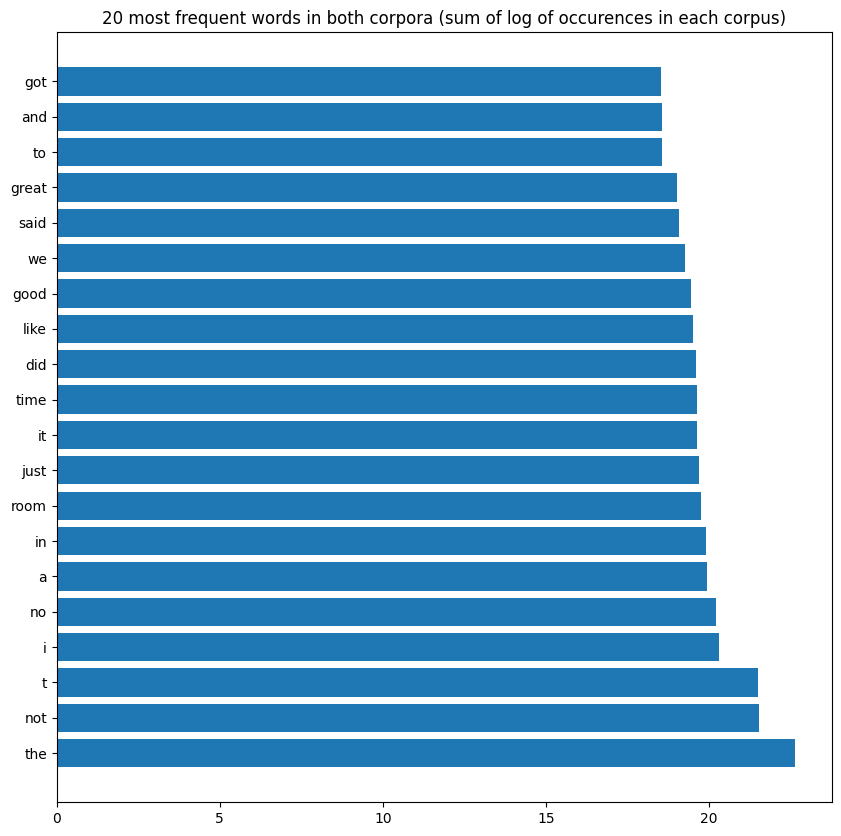

In [151]:
## Add column with log of number of occurrences of word in corpus to dataframe
df_common['log_n_occurrences_trip'] = [np.log(word_counts_trip[word]) for word in df_common['word']]
df_common['log_n_occurrences_scifi'] = [np.log(word_counts_scifi[word]) for word in df_common['word']]
df_common['log_n_occurrences_trip'] = df_common['log_n_occurrences_trip'].astype(float)
df_common['log_n_occurrences_scifi'] = df_common['log_n_occurrences_scifi'].astype(float)

## Add column with sum of log of number of occurrences of word in corpus to dataframe
df_common['sum_log_n_occurrences'] = df_common['log_n_occurrences_trip'] + df_common['log_n_occurrences_scifi']

## Sort dataframe by sum of log of number of occurrences of word in corpus
df_common = df_common.sort_values(by=['sum_log_n_occurrences'], ascending=False)

## Plot the 20 most frequent words in both corpora
plt.figure(figsize=(10, 10))
plt.barh(df_common['word'][:20], df_common['sum_log_n_occurrences'][:20])
plt.title('20 most frequent words in both corpora (sum of log of occurences in each corpus)')
plt.show()


#### Lastly, we choose two words that are frequent in both corpora

In [155]:
## Define 2 words that are frequent in both corpora
words_trip_scifi = ['room', 'time']

## Compute nearest neighbors for the 2 words in both corpora and write them to a dataframe
df_trip_scifi = pd.DataFrame(columns=['word', 'nn1', 'nn2', 'nn3', 'nn4', 'nn5'])
for word in words_trip_scifi:
    nearest_n = get_closest_word(word, model=model_trip, vocab=vocab_trip, vect=vect_trip)
    df_trip_scifi = pd.concat([df_trip_scifi, pd.DataFrame({'word': [word], 'nn1': [nearest_n[0][0]], 'nn2': [nearest_n[1][0]], 'nn3': [nearest_n[2][0]], 'nn4': [nearest_n[3][0]], 'nn5': [nearest_n[4][0]]})], ignore_index=True)

for word in words_trip_scifi:
    nearest_n = get_closest_word(word, model=model_scifi, vocab=vocab_scifi, vect=vect_scifi)
    df_trip_scifi = pd.concat([df_trip_scifi, pd.DataFrame({'word': [word], 'nn1': [nearest_n[0][0]], 'nn2': [nearest_n[1][0]], 'nn3': [nearest_n[2][0]], 'nn4': [nearest_n[3][0]], 'nn5': [nearest_n[4][0]]})], ignore_index=True)

## Add column with corpus to dataframe
df_trip_scifi['corpus'] = ['trip'] * 2 + ['scifi'] * 2

## Add column with number of occurrences of word in corpus to dataframe
df_trip_scifi['n_occurrences_trip'] = [word_counts_trip[word] for word in df_trip_scifi['word']]
df_trip_scifi['n_occurrences_scifi'] = [word_counts_scifi[word] for word in df_trip_scifi['word']]

print('Nearest neighbors for words that are frequent in both corpora')
display(df_trip_scifi)

Nearest neighbors for words that are frequent in both corpora


,word,nn1,nn2,nn3,nn4,nn5,corpus,n_occurrences_trip,n_occurrences_scifi
0,room,celler,thirties,utilising,departure,rolled,trip,35367,10873
1,time,furthermore,acts,gasshem,mamosa,srambled,trip,10135,32907
2,room,whosever,authorides,highpoints,yourse,storij,scifi,35367,10873
3,time,widemos,freshly,tregasid,tactless,levantman,scifi,10135,32907


## Charts

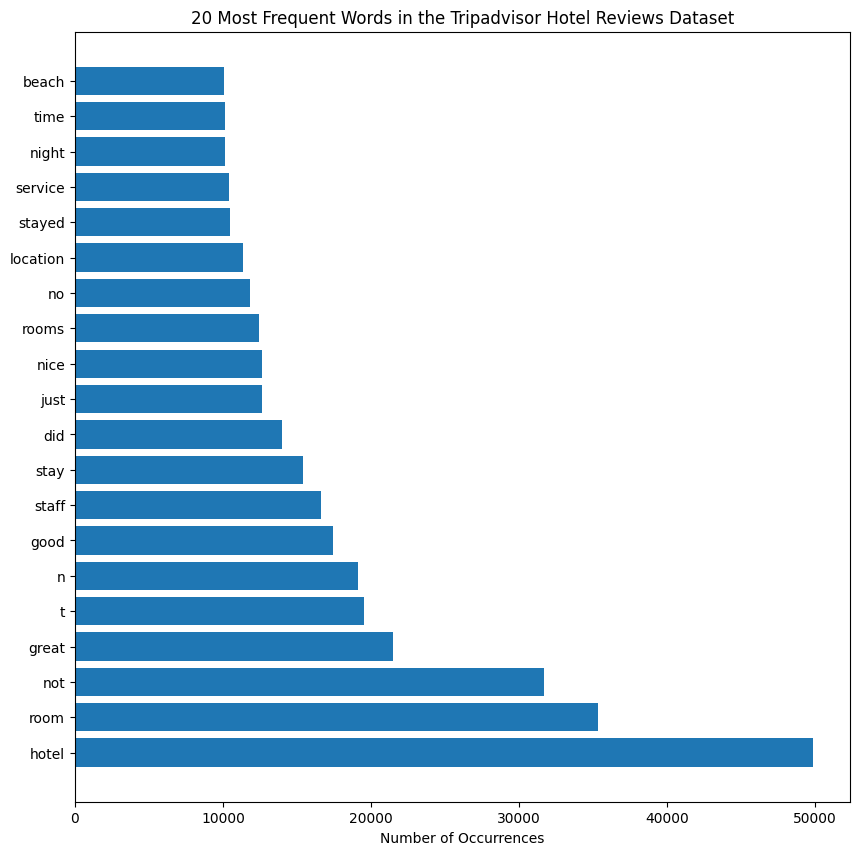

In [22]:
## Plot vertical bar chart of the top 20 words in the dictionary word_counts_trip_frequent
plt.figure(figsize=(10, 10))
plt.barh(list(word_counts_trip_frequent.keys())[:20], list(word_counts_trip_frequent.values())[:20])
plt.title('20 Most Frequent Words in the Tripadvisor Hotel Reviews Dataset')
plt.xlabel('Number of Occurrences')
plt.show()

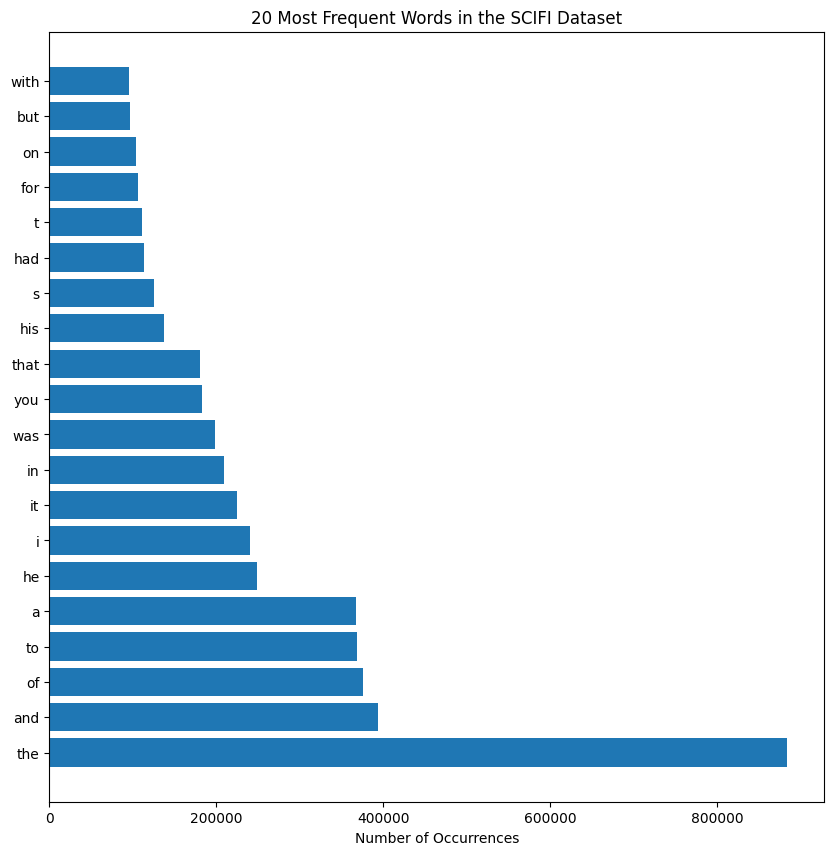

In [23]:
## Plot vertical bar chart of the top 20 words in the dictionary word_counts_scifi_frequent
plt.figure(figsize=(10, 10))
plt.barh(list(word_counts_scifi_frequent.keys())[:20], list(word_counts_scifi_frequent.values())[:20])
plt.title('20 Most Frequent Words in the SCIFI Dataset')
plt.xlabel('Number of Occurrences')
plt.show()